In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *

2024-01-21 15:24:26.326219: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 15:24:26.973585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-21 15:24:26.973660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-21 15:24:26.973667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


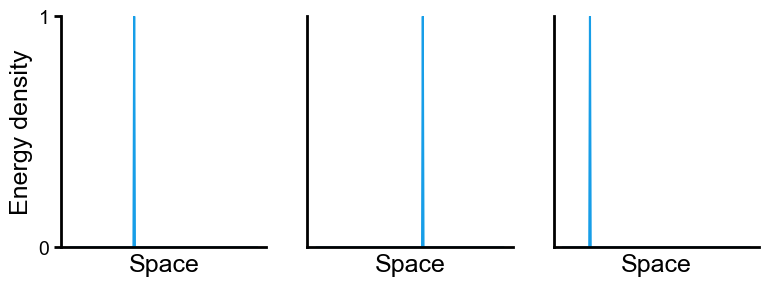

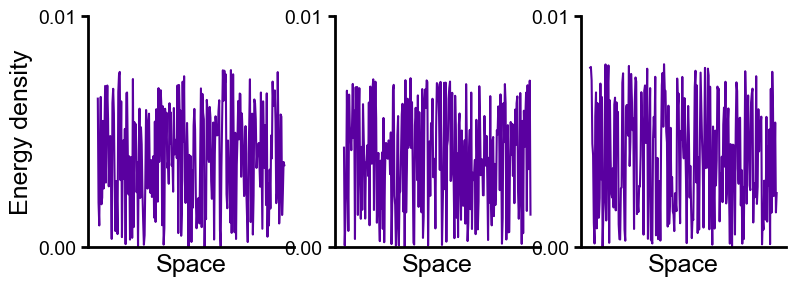

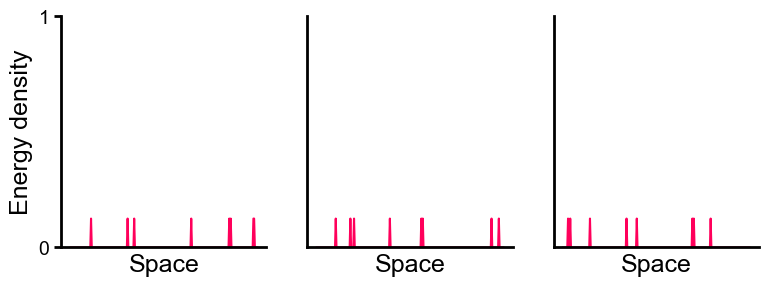

In [14]:
N_objects = 2000
noise_sigma = 1e-3
seed = 2113270
num_nyquist_samples = 16

upsampling_factor = 16

objects_dict = {
  'delta_uniform': lambda : np.array([generate_random_object('delta', num_deltas=1, seed=seed + i, object_size=num_nyquist_samples*upsampling_factor,
                                                             ) for i in range(N_objects)]),
  'white_noise': lambda : np.array([generate_random_object('white_noise', seed=seed + i, object_size=num_nyquist_samples*upsampling_factor,
                                                           ) for i in range(N_objects)]),  
  '8_deltas_uniform': lambda :np.array([generate_random_object('delta', num_deltas=8, seed=seed + i, object_size=num_nyquist_samples*upsampling_factor,
                                                               ) for i in range(N_objects)]),
}

# plot examples of each object
fig, ax = plt.subplots(1, 3, figsize=(9, 3), )
for i in range(3):
  ax[i].plot(objects_dict['delta_uniform']()[i], label='delta_uniform', color=get_color_cycle()[0])
  ax[i].set(xticks=[], yticks=[0, 1] if i == 0 else [], ylim=[0, 1], xlabel='Space', ylabel='Energy density' if i == 0 else '')
clear_spines(ax)
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'example_objects_delta_uniform' + '.pdf', transparent=True)

fig, ax = plt.subplots(1, 3, figsize=(9, 3), )
for i in range(3):
  ax[i].plot(objects_dict['white_noise']()[i], label='white_noise', color=get_color_cycle()[1])
  ax[i].set(xticks=[], yticks=[0, .01], ylim=[0, .01], xlabel='Space', ylabel='Energy density' if i == 0 else '')
clear_spines(ax)
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'example_objects_white_noise' + '.pdf', transparent=True)

fig, ax = plt.subplots(1, 3, figsize=(9, 3), )
for i in range(3):
  ax[i].plot(objects_dict['8_deltas_uniform']()[i], label='8_deltas_uniform', color=get_color_cycle()[2])
  ax[i].set(xticks=[], yticks=[0, 1] if i == 0 else [], ylim=[0, 1], xlabel='Space', ylabel='Energy density' if i == 0 else '')
clear_spines(ax)
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'example_objects_8_deltas_uniform' + '.pdf', transparent=True)

In [3]:
# run a quick optimization to get a sinc-like psf
N_objects = 2000

objects_fn = lambda : np.array([generate_random_object('delta') for i in range(N_objects)])
initial_kernel, initial_params, optimized_params, objects, initial_mi, optimized_mi = optimize_PSF_and_estimate_mi(objects_fn, 1e-2, num_nyquist_samples=num_nyquist_samples, max_epochs=1000)

initial loss -1.2913118577578873
computing initial mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:223: UserWarning: 1.03% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")
2024-01-21 15:25:38.554533: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


computing optimized mi


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/information_estimation.py:223: UserWarning: 3.29% of pixels are negative.
  warnings.warn(f"{np.sum(clean_images_if_available < 0) / clean_images_if_available.size:.2%} of pixels are negative.")


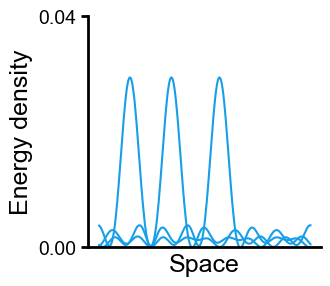

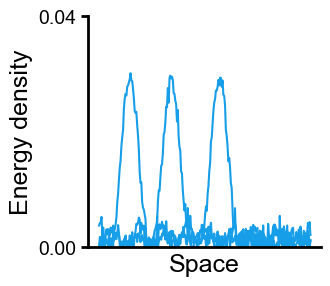

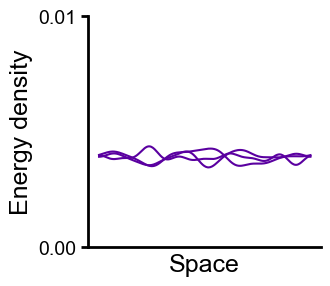

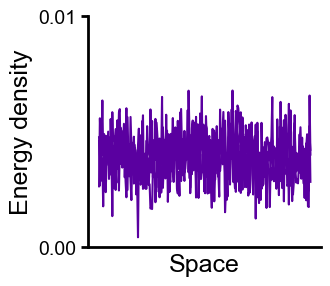

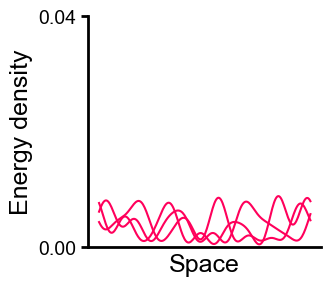

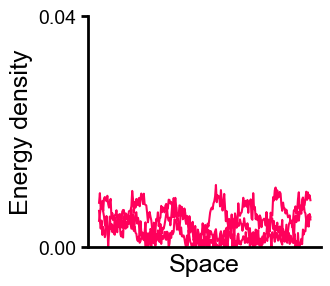

: 

In [17]:
optimized_kernel = signal_from_params(optimized_params, upsampled_signal_length=list(objects_dict.values())[0]().shape[1])

# convolve with optimized kernel
kernel = np.roll(optimized_kernel, optimized_kernel.size // 2 - np.argmax(optimized_kernel))
kernel = np.fft.fftshift(kernel)
conv_mat = make_convolutional_encoder(kernel)

for k, (obj_name, y_max) in enumerate(zip(objects_dict.keys(), [.04, .01, .04])):
    objects = objects_dict[obj_name]()
    input_signals = objects[:3]
    # do the convolution
    output_signals = input_signals @ conv_mat.T

    # plot the output signals
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), )
    for i in range(3):
      ax.plot(output_signals[i], label='output', color=get_color_cycle()[k])
      ax.set(xticks=[], yticks=[0, y_max], ylim=[0, y_max], xlabel='Space', ylabel='Energy density')
    clear_spines(ax)
    fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'example_signals_' + obj_name + '_convolved' + '.pdf', transparent=True)

    # make noisy signals
    noisy_signals = output_signals + onp.random.randn(*output_signals.shape) * noise_sigma
    # make positive
    noisy_signals = np.maximum(noisy_signals, 0)
    # plot them in the same way
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), )
    for i in range(3):
      ax.plot(noisy_signals[i], label='noisy', color=get_color_cycle()[k])
      ax.set(xticks=[], yticks=[0, y_max], ylim=[0, y_max], xlabel='Space', ylabel='Energy density')
    clear_spines(ax)
    fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'example_signals_' + obj_name + '_noisy' + '.pdf', transparent=True)
